# Training a Jet Tagging with **Conv2D** 

---
In this notebook, we perform a Jet identification task using a Conv2D multiclass classifier.
The problem consists in identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on a jet image, i.e., a 2D histogram of the transverse momentum ($p_T$) deposited in each of 100x100
bins of a square window of the ($\eta$, $\phi$) plane, centered along the jet axis.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

To type shell commands, we start the command line with !

In [4]:
! git clone https://github.com/pierinim/tutorials.git

Cloning into 'tutorials'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 40 (delta 8), reused 21 (delta 3), pack-reused 0
Unpacking objects: 100% (40/40), done.
Checking out files: 100% (20/20), done.


In [5]:
! ls tutorials/HiggsSchool/data

jetImage_7_100p_0_10000.h5     jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5 jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5 jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5 jetImage_7_100p_80000_90000.h5


In [6]:
target = np.array([])
jetImage = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['tutorials/HiggsSchool/data/jetImage_7_100p_30000_40000.h5',
           'tutorials/HiggsSchool/data/jetImage_7_100p_60000_70000.h5',
            'tutorials/HiggsSchool/data/jetImage_7_100p_50000_60000.h5',
            'tutorials/HiggsSchool/data/jetImage_7_100p_10000_20000.h5',
            'tutorials/HiggsSchool/data/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    myjetImage = np.array(f.get("jetImage"))
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    jetImage = np.concatenate([jetImage, myjetImage], axis=0) if jetImage.size else myjetImage
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
print(target.shape, jetImage.shape)

Appending tutorials/HiggsSchool/data/jetImage_7_100p_30000_40000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_60000_70000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_50000_60000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_10000_20000.h5
Appending tutorials/HiggsSchool/data/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 100)


The dataset consists of XXX with up to 100 particles in each jet. These 100 particles have been used to fill the 100x100 jet images.

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(jetImage, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(33500, 100, 100) (16500, 100, 100) (33500, 5) (16500, 5)


In keras, images are representable as $n \times m \times k$ tensors, where $n \times m$ are the pixel dimenions and $k$ is the number of channels (e.g., 1 in a black\&while image, 3 for an RGB image). In our case, k=1. To comply to this, we add the channel index by reshaping the image dataset

In [8]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(33500, 100, 100, 1) (16500, 100, 100, 1) (33500, 5) (16500, 5)


# Conv 2D model building

In [9]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Dropout, Flatten
from keras.layers import MaxPooling2D, BatchNormalization, Activation
from keras.utils import plot_model
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [21]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
dropoutRate = 0.25

In [22]:
image_shape = (img_rows, img_cols, 1)
####
inputImage = Input(shape=(image_shape))
x = Conv2D(5, kernel_size=(5,5), data_format="channels_last", strides=(1, 1), padding="same")(inputImage)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (5,5))(x)
x = Dropout(dropoutRate)(x)
#
x = Conv2D(3, kernel_size=(3,3), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (3,3))(x)
x = Dropout(dropoutRate)(x)
#
x = Flatten()(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputImage, outputs=output)

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 5)       130       
_________________________________________________________________
batch_normalization_4 (Batch (None, 100, 100, 5)       20        
_________________________________________________________________
activation_4 (Activation)    (None, 100, 100, 5)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 5)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 5)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 3)         138       
__________

We now train the model

In [24]:
batch_size = 128
n_epochs = 20

In [25]:
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 53600 samples, validate on 26400 samples
Epoch 1/20
 - 205s - loss: 1.5708 - val_loss: 1.4752
Epoch 2/20
 - 204s - loss: 1.4524 - val_loss: 1.3480
Epoch 3/20
 - 205s - loss: 1.3530 - val_loss: 1.2450
Epoch 4/20
 - 196s - loss: 1.2924 - val_loss: 1.2221
Epoch 5/20
 - 192s - loss: 1.2673 - val_loss: 1.1997
Epoch 6/20
 - 193s - loss: 1.2488 - val_loss: 1.1746
Epoch 7/20
 - 193s - loss: 1.2414 - val_loss: 1.1701
Epoch 8/20
 - 193s - loss: 1.2304 - val_loss: 1.1611
Epoch 9/20
 - 209s - loss: 1.2246 - val_loss: 1.1552
Epoch 10/20
 - 196s - loss: 1.2248 - val_loss: 1.1541
Epoch 11/20
 - 212s - loss: 1.2162 - val_loss: 1.1491
Epoch 12/20
 - 208s - loss: 1.2129 - val_loss: 1.1412
Epoch 13/20
 - 224s - loss: 1.2100 - val_loss: 1.1471
Epoch 14/20
 - 210s - loss: 1.2077 - val_loss: 1.1374
Epoch 15/20
 - 2798s - loss: 1.2062 - val_loss: 1.1276
Epoch 16/20
 - 217s - loss: 1.2010 - val_loss: 1.1314
Epoch 17/20
 - 211s - loss: 1.1998 - val_loss: 1.1300
Epoch 18/20

Epoch 00018: ReduceLROnPlat

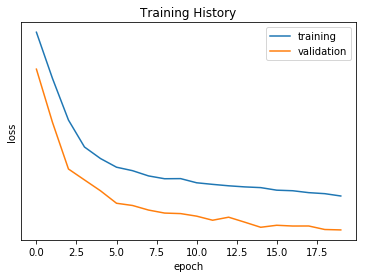

In [28]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

We save on disk the best model, result of the training, to be then use for inference

In [29]:
model_json = model.to_json()
with open("tutorials/HiggsSchool/models/jetTagger_Conv2D.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("tutorials/HiggsSchool/models/jetTagger_Conv2D.h5")

# Building the ROC Curves

In [30]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

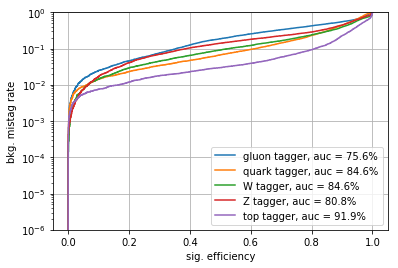

In [31]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()